## PINNS for Steady Cavity Problem
Solving the 1D unsteady diffusion equation using a Physics Informed Neural Network (PINN).  
The Equation is given by:
$$\frac {\partial u} {\partial t} - \mu \frac {\partial^2 u} {\partial x^2} = 0$$
The Domain for $x$ and $t$ are $x\in [0,1]$, and $t\in [0,1]$.  
The ICs/BSs are (here $T=1$):
$$u(x,t=0)=sin(\frac {2\pi x} {T})$$
$$u(x=0,t)=0$$
$$u(x=1,t)=0$$
$$u_x(x=0,t)=u_x(x=1,t)$$


In [112]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt

### Define PINNs network class with Fourier Feature Mapping

In [113]:
class ffm2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.B = nn.Parameter(torch.normal(mean=0, std=10, size=(in_dim, out_dim), requires_grad=False))
    
    def forward(self, x):
        x_map = torch.matmul(x, self.B)
        return torch.cat([torch.cos(x_map), torch.sin(x_map)], -1)

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=64, out_dim=3, activation=nn.Tanh()):
        """
        Parameters
        -------------
        in_dim: the input dimensions - number of independant variables
        HL_dim: the width of the network
        out_dim: the output dimensions - number of dependant variables
        activation: The activation function you wish to use in the network - the default is nn.Tanh()
        """
        super().__init__()
        
        # define the network architecture
        # network = [nn.Linear(in_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, out_dim)]
        network = [ffm2(in_dim, HL_dim),
                   nn.Linear(HL_dim*2, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.net = nn.Sequential(*network) 
    
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    
    
    def compute_loss(self, x, y, Nx, Ny, u_i):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0]
        v = net_out[:,1]
        p = net_out[:,2]
        print(type(u))
        # u.requires_grad=True
        # v.requires_grad=True
        # p.requires_grad=True

        # compute PDE derivatives using auto grad
        # we need to specify the dimension of the output array
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_x = grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y
        res2 = u*u_x + v*u_y + p_x - 1/Re*(u_xx+u_yy)
        res3 = u*v_x + v*v_y + p_y - 1/Re*(v_xx+v_yy)
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]

        # Calculate indices for the boundary condition range
        start_idx = int(Ny / 4)
        end_idx = int(3 * Ny / 4)
        
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, 0], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,0], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[start_idx:end_idx, -1], torch.ones_like(u_reshaped[start_idx:end_idx, -1]) * u_i) \
                + loss_fun(v_reshaped[start_idx:end_idx, -1], torch.zeros_like(v_reshaped[start_idx:end_idx, -1])) \
        
    
        return pde_loss, bc_loss


### Define Model and Optimizer

In [114]:
model = PINNs_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [115]:
# num of points in the domain
Nx, Ny = 80, 80
u_i = 5 #m/s
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1
dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)
for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j
print(type(x))
print(x.shape)

<class 'torch.Tensor'>
torch.Size([80, 80])


### Training the PINNs network

In [116]:
N_epoches = 500
loss_per_epoch = np.zeros((N_epoches,3))
for epoch in range(N_epoches):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny , u_i)

    # compute total loss
    total_loss = eq_loss + 10*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_per_epoch[epoch,0] = eq_loss
    loss_per_epoch[epoch,1] = BC_loss
    loss_per_epoch[epoch,2] = total_loss
    print(f"epoch: {epoch}, loss: {total_loss}")


<class 'torch.Tensor'>
epoch: 0, loss: 261.43524169921875
<class 'torch.Tensor'>
epoch: 1, loss: 251.96885681152344
<class 'torch.Tensor'>
epoch: 2, loss: 242.71644592285156
<class 'torch.Tensor'>
epoch: 3, loss: 233.08297729492188
<class 'torch.Tensor'>
epoch: 4, loss: 222.7108917236328
<class 'torch.Tensor'>
epoch: 5, loss: 211.44007873535156
<class 'torch.Tensor'>
epoch: 6, loss: 199.24639892578125
<class 'torch.Tensor'>
epoch: 7, loss: 186.26907348632812
<class 'torch.Tensor'>
epoch: 8, loss: 172.84075927734375
<class 'torch.Tensor'>
epoch: 9, loss: 159.49655151367188
<class 'torch.Tensor'>
epoch: 10, loss: 146.92617797851562
<class 'torch.Tensor'>
epoch: 11, loss: 135.81385803222656
<class 'torch.Tensor'>
epoch: 12, loss: 126.56501007080078
<class 'torch.Tensor'>
epoch: 13, loss: 119.0495376586914
<class 'torch.Tensor'>
epoch: 14, loss: 112.52105712890625
<class 'torch.Tensor'>
epoch: 15, loss: 106.04794311523438
<class 'torch.Tensor'>
epoch: 16, loss: 99.17024993896484
<class 'to

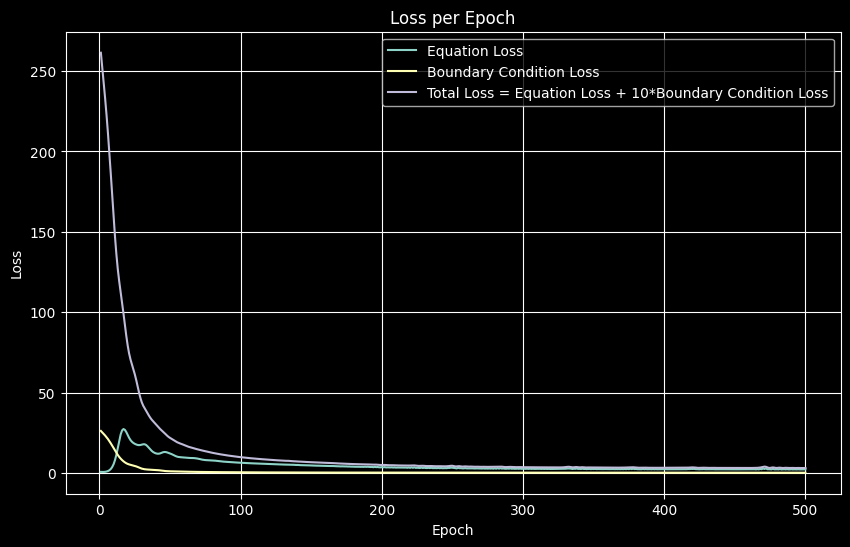

In [117]:
epocs_array = np.linspace(1,N_epoches,N_epoches)

plt.figure(figsize=(10, 6))  # Optional: specify the figure size
plt.plot(epocs_array, loss_per_epoch[:,0], '-')
plt.plot(epocs_array, loss_per_epoch[:,1], '-')
plt.plot(epocs_array, loss_per_epoch[:,2], '-')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True) 
plt.legend(['Equation Loss','Boundary Condition Loss','Total Loss = Equation Loss + 10*Boundary Condition Loss'])

# Show the plot
plt.show()

x_np:  (80, 80)
x_np:  <class 'numpy.ndarray'>
u:  torch.Size([6400])
v:  torch.Size([6400])
x_np:  (80, 80)
x_np:  <class 'numpy.ndarray'>
x:  torch.Size([80, 80])
x:  <class 'torch.Tensor'>
u:  <class 'torch.Tensor'>


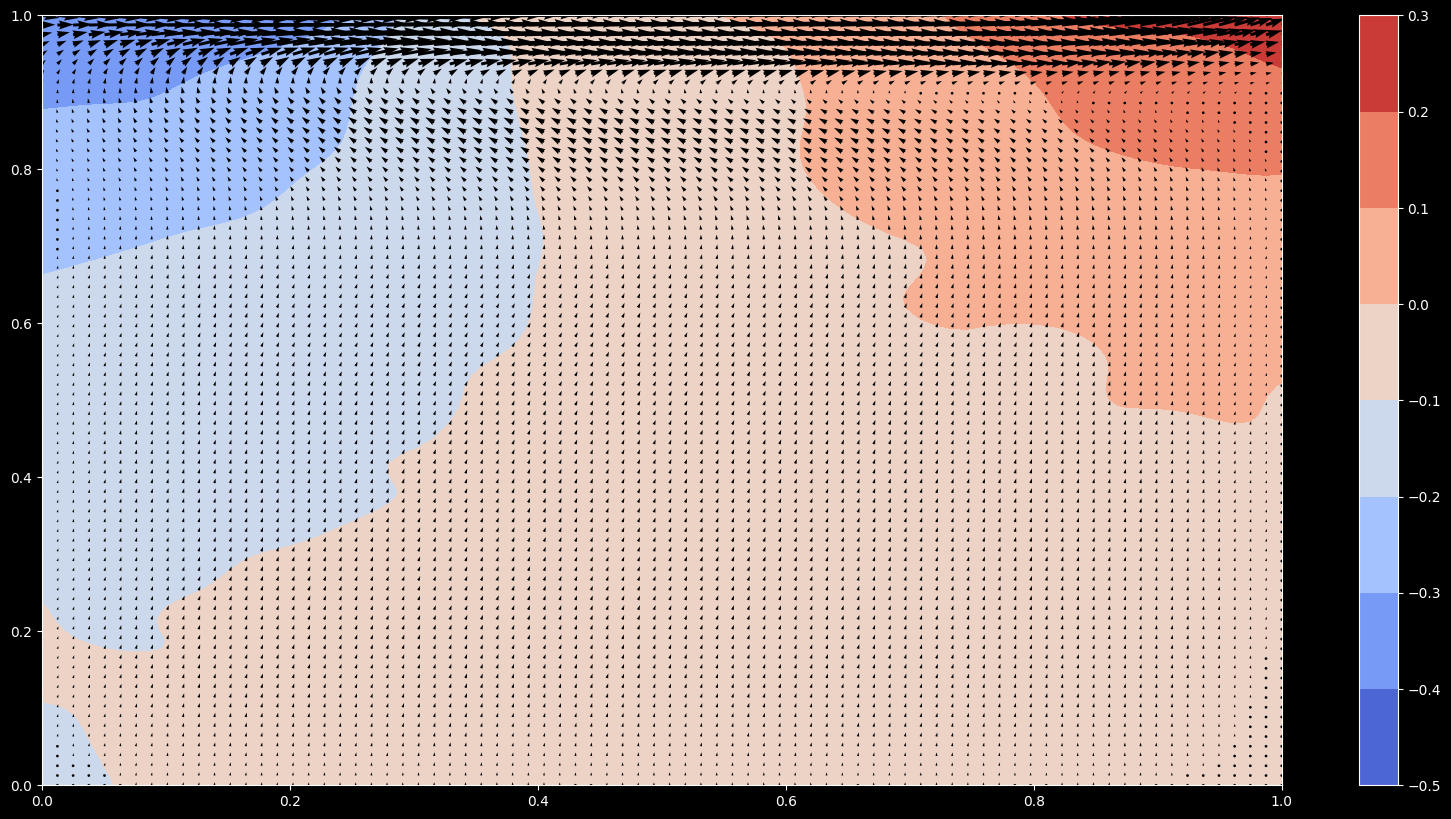

[0.625267  0.7657704 0.9168109 1.0784824 1.2493417 1.4269111 1.6089597
 1.7944908 1.9835315 2.1763752 2.3733327 2.5749009 2.7817185 2.9943345
 3.2130644 3.437807  3.667376  3.8984745 4.1248527 4.337416  4.5256944
 4.680515  4.797044  4.8765903 4.9257426 4.953241  4.9667068 4.9712396
 4.970057  4.9656725 4.9603887 4.9560905 4.953885  4.9539685 4.9557414
 4.958137  4.96011   4.961122  4.9613585 4.961387  4.96149   4.961245
 4.9598184 4.956839  4.9530015 4.9498224 4.948648  4.9497123 4.952104
 4.9545426 4.956199  4.9568143 4.9560847 4.952689  4.9434958 4.9230714
 4.883818  4.817101  4.7156324 4.576322  4.401759  4.199198  3.977793
 3.7459486 3.5100186 3.2743366 3.0417387 2.8139603 2.5918658 2.3757894
 2.1658738 1.9621274 1.7643728 1.5725741 1.3874054 1.2104847 1.0436962
 0.8883957 0.7452789 0.6153294]
max u(x=0) :  0.47920752
max v(x=0) :  0.14762735


In [118]:
#  x_np, y_np = np.meshgrid(x, y)
x_np = x.detach().numpy()
y_np = y.detach().numpy()
print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))
net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
u=net[:, 0]
v=net[:, 1]
p=net[:, 2]
print("u: ",u.shape)
print("v: ",v.shape)

print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))

print("x: ",x.shape)
print("x: ",type(x))
print("u: ",type(u))

u_np = 1*u.detach().numpy().reshape(Nx,Ny) # convert into a np array
v_np = 1*v.detach().numpy().reshape(Nx,Ny) # convert into a np array
p_np = p.detach().numpy().reshape(Nx,Ny) # convert into a np array

plt.style.use("dark_background")
plt.figure(figsize=(20, 10))
plt.contourf(x_np , y_np, p_np, cmap="coolwarm")
plt.colorbar()

plt.quiver(x_np , y_np , u_np , v_np , color="black")
#plt.streamplot(x_np, y_np, u_np, v_np, color="red")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
print(u_np[:,-1])

print("max u(x=0) : " , u_np[0,1:-1].max() )
print("max v(x=0) : " , v_np[0].max() )

In [119]:
print(BC_loss)
print(eq_loss)

tensor(0.0822, grad_fn=<AddBackward0>)
tensor(2.1845, grad_fn=<AddBackward0>)


In [120]:
# once you have a complicated solution so the NN is finding it hard to learn functions.
# to enhance the convergance is 
# MLPs can't capture high frequency details. The proposed solution is FFM
# Fourier feature mapping
# PINNs compared to Numerical Solvers is garbage because high frequency data is not captured.
# CFD simulations are usually done in FORTRAN 